# SVM classification on the Seattle Crime dataset
Author: Tomas Hobza

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
import time
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, precision_score, recall_score


# set random seed for reproducibility
np.random.seed(0)

## 0. Load the dataset

In [2]:
# Load the ARFF file
data, meta = arff.loadarff('Seattle_Crime_Data_06-23-2019-4.arff')

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

# Decode byte strings (ARFF stores nominal/string attributes as bytes)
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')

Consolidated preprocessing function:

In [3]:
def preprocess_crime(df, RARITY_THRESHOLD = 1000, seed=42, test_size=0.2):
  new_df = df.copy()

  # == 1. handle missing values ==
  # unify unknown values into NAs
  new_df = new_df.replace(['UNKNOWN', '?', 'Unknown', 'unknown'], pd.NA)
  print(new_df.isnull().sum()[new_df.isnull().sum() > 0])
  # drop rows with missing Occurred_Time or Reported_Time
  new_df = new_df.dropna(subset=['Occurred_Time', 'Reported_Time'])
  # for missing values in other columns, we can substitute them as a unified "UNKNOWN" category.
  new_df = new_df.fillna('UNKNOWN')
  print("Number of NAs:", new_df.isnull().sum()[new_df.isnull().sum() > 0])

  # == 2. drop the UID column Report_Number ==
  new_df = new_df.drop(columns=['Report_Number'])

  # == 3. drop Crime_Subcategory to prevent leakage ==
  new_df = new_df.drop(columns=["Crime_Subcategory"])

  # == 4. split occurred_time and reported_time into hour and minute and
  # sin/cos tranform them to keep the relationship that 00:00 comes after 23:59 ==
  # split "Reported_Time" into "reported_hour" and "reported_minute"
  new_df["reported_hour"] = new_df["Reported_Time"].apply(lambda x: int(x/100) if not pd.isna(x) else pd.NA)
  new_df["reported_minute"] = new_df["Reported_Time"].apply(lambda x: x % 100 if not pd.isna(x) else pd.NA)
  # make hours and minutes integers
  new_df["reported_hour"] = new_df["reported_hour"].astype("Int64")
  new_df["reported_minute"] = new_df["reported_minute"].astype("Int64")
  # cyclical encoding (sin/cos)
  new_df["reported_hour_sin"] = np.sin(2 * np.pi * new_df["reported_hour"] / 24)
  new_df["reported_hour_cos"] = np.cos(2 * np.pi * new_df["reported_hour"] / 24)
  new_df["reported_minute_sin"] = np.sin(2 * np.pi * new_df["reported_minute"] / 60)
  new_df["reported_minute_cos"] = np.cos(2 * np.pi * new_df["reported_minute"] / 60)

  # split "Occurred_Time" into "occured_hour" and "occured_minute"
  new_df["occured_hour"] = new_df["Occurred_Time"].apply(lambda x: int(x/100) if not pd.isna(x) else pd.NA)
  new_df["occured_minute"] = new_df["Occurred_Time"].apply(lambda x: x % 100 if not pd.isna(x) else pd.NA)
  # make hours and minutes integers
  new_df["occured_hour"] = new_df["occured_hour"].astype("Int64")
  new_df["occured_minute"] = new_df["occured_minute"].astype("Int64")
  # cyclical encoding (sin/cos)
  new_df["occured_hour_sin"] = np.sin(2 * np.pi * new_df["occured_hour"] / 24)
  new_df["occured_hour_cos"] = np.cos(2 * np.pi * new_df["occured_hour"] / 24)
  new_df["occured_minute_sin"] = np.sin(2 * np.pi * new_df["occured_minute"] / 60)
  new_df["occured_minute_cos"] = np.cos(2 * np.pi * new_df["occured_minute"] / 60)

  # drop Reported_Time, Occurred_Time, reported_hour, reported_minute, occured_hour, occured_minute
  new_df = new_df.drop(columns=["Reported_Time", "Occurred_Time", "reported_hour", "reported_minute", "occured_hour", "occured_minute"])

  # == 5. handle class imbalance ==
  # check class distribution
  class_counts = new_df['Primary_Offense_Description'].value_counts()
  print("Original target class distribution: ", class_counts)
  rare_classes = class_counts[class_counts < RARITY_THRESHOLD].index
  print(f"Number of rare classes (less than {RARITY_THRESHOLD} instances): {len(rare_classes)}")
  new_df['Primary_Offense_Description'] = new_df['Primary_Offense_Description'].apply(lambda x: 'OTHER' if x in rare_classes else x)
  print("New target class distribution: ", new_df['Primary_Offense_Description'].value_counts())

  # == 6. split the data into training and testing ==
  X = new_df.drop(columns=['Primary_Offense_Description'])
  y = new_df['Primary_Offense_Description']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
  print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

  # == 7. one-hot encode nominal features ==
  # encode separately
  X_train = pd.get_dummies(X_train, columns=['Precinct', 'Sector', 'Beat', 'Neighborhood'])
  X_test = pd.get_dummies(X_test, columns=['Precinct', 'Sector', 'Beat', 'Neighborhood'])
  # align (ensures same columns)
  X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

  return X_train, X_test, y_train, y_test

In [4]:
print(df.shape)

(523590, 9)


As the dataset contains 523590 samples in total, given our computational power constraints, we'll need to downsample the datasets.

In [5]:
# Downsampling parameter
SAMPLE_SIZE = 50000  # Use 50k samples (adjust as needed)

## 1. Experiment - find the optimal RARITY_THRESHOLD

The goal is to find the optimal `RARITY_THRESHOLD`. This hyper-parameter is a preprocessing hyperparameter. The issue is that the dataset has an extreme inbalance of the classes in the target attribute. 

We can observe the imbalance in the following table:

In [6]:
# print the target class distribution
print("Overall target class distribution: ", df['Primary_Offense_Description'].value_counts())

Overall target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                   131297
THEFT-SHOPLIFT                    48638
THEFT-OTH                         47275
VEH-THEFT-AUTO                    37840
BURGLARY-FORCE-RES                27984
                                  ...  
NARC-SMUGGLE-HEROIN                   1
HOMICIDE-NEG-MANS-GUN                 1
NARC-SELL-BARBITUATE                  1
NARC-MANUFACTURE-HALLUCINOGEN         1
HOMICIDE-NEG-MANS-WEAPON              1
Name: count, Length: 144, dtype: int64


We can see that the most represented classes have hundrets of thousand of observations, while the least represented classes have as little as only one observation.

The `RARITY_THRESHOLD` hyperparameter controls the threshold under which all classes are relabeled as "Other". There is a caveat though, we can assume that increasing this hyperparameter will always lead to a better performace. The reason is that with less classes to categorize observations as, the probability of categorizing wrong goes down. However, this is a lossy transformation and we loose information making the model in practice less usable.

Nevertheless, we find it still interesting to do this experiment mainly from the computational cost perspective as our limited computational power would make further experiments very difficult.

In [7]:
thresholds = [100, 500, 1000, 2000, 5000]
results = []

for threshold in thresholds:
    print(f"\n=== Experiment with RARITY_THRESHOLD = {threshold} ===")
    
    # preprocess the data with the current threshold
    X_train, X_test, y_train, y_test = preprocess_crime(df, RARITY_THRESHOLD=threshold)
    
    # DOWNSAMPLE: Stratified sampling to keep all classes
    print(f"Original training size: {len(X_train):,}")
    
    if len(X_train) > SAMPLE_SIZE:
        X_train_sample, _, y_train_sample, _ = train_test_split(
            X_train, y_train,
            train_size=SAMPLE_SIZE,
            stratify=y_train,  # ← This preserves class distribution!
            random_state=42
        )
        print(f"Downsampled to: {len(X_train_sample):,} samples")
        print(f"Classes preserved: {y_train_sample.nunique()} / {y_train.nunique()}")
    else:
        X_train_sample = X_train
        y_train_sample = y_train
        print(f"No downsampling needed (dataset smaller than {SAMPLE_SIZE:,})")
    
    # train with FIXED C=1.0 (don't tune yet!)
    model = LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,  # ← Reduced from 2000 for speed
        random_state=42,
        verbose=0  # ← Set to 1 if you want progress updates
    )
    
    # measure training time
    start = time.time()
    model.fit(X_train_sample, y_train_sample)  # ← Use sample
    train_time = time.time() - start
    
    # evaluate on FULL test set (don't downsample test!)
    y_pred = model.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    
    results.append({
        'threshold': threshold,
        'n_classes': y_train.nunique(),
        'train_samples': len(X_train_sample),  # Record sample size
        'original_train_size': len(X_train),
        'balanced_accuracy': acc,
        'train_time': train_time,
        'C': 1.0
    })
    
    print(f"Classes: {y_train.nunique()}")
    print(f"Balanced Accuracy: {acc:.4f}")
    print(f"Time: {train_time:.1f}s ({train_time/60:.1f} min)")

# Show results
df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("EXPERIMENT RESULTS")
print("="*60)
print(df_results)


=== Experiment with RARITY_THRESHOLD = 100 ===
Occurred_Time           2
Reported_Time           2
Crime_Subcategory     262
Precinct             3352
Sector               3346
Beat                 3298
Neighborhood         3366
dtype: int64
Number of NAs: Series([], dtype: int64)
Original target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                   131297
THEFT-SHOPLIFT                    48637
THEFT-OTH                         47275
VEH-THEFT-AUTO                    37840
BURGLARY-FORCE-RES                27984
                                  ...  
NARC-SMUGGLE-HEROIN                   1
HOMICIDE-NEG-MANS-GUN                 1
NARC-SELL-BARBITUATE                  1
NARC-MANUFACTURE-HALLUCINOGEN         1
HOMICIDE-NEG-MANS-WEAPON              1
Name: count, Length: 144, dtype: int64
Number of rare classes (less than 100 instances): 45
New target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                      131297
THEFT-SHOPLIFT   

We have tried preprocessing the dataset in 5 different ways by changing the `RARITY_THRESHOLD`. We have tried the values: 100, 500, 1000, 2000, 5000.

array([[<Axes: xlabel='threshold'>],
       [<Axes: xlabel='threshold'>],
       [<Axes: xlabel='threshold'>]], dtype=object)

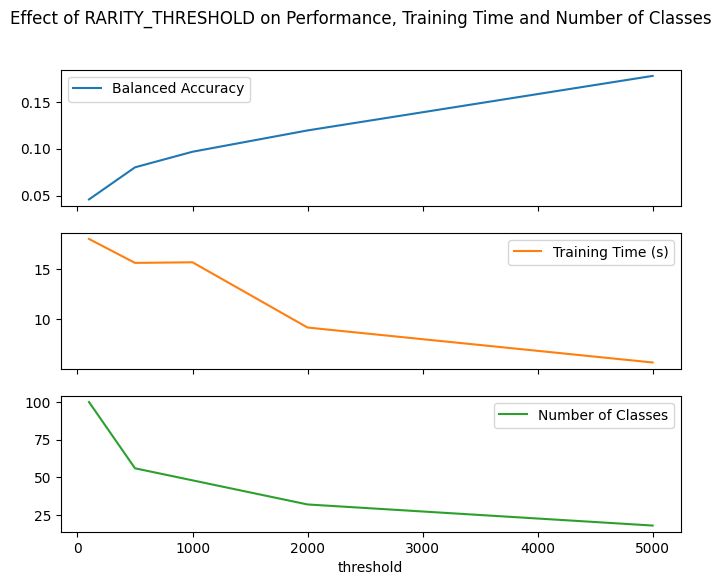

In [8]:
df_results_plot = df_results.copy()
df_results_plot = df_results_plot.set_index('threshold')
df_results_plot = df_results_plot[['balanced_accuracy', 'train_time', 'n_classes']]
df_results_plot.columns = ['Balanced Accuracy', 'Training Time (s)', 'Number of Classes']
df_results_plot.plot(subplots=True, layout=(3,1), figsize=(8,6), title="Effect of RARITY_THRESHOLD on Performance, Training Time and Number of Classes")

As predicted the accuracy increses with the number of classes being merged into the "Other" class. We can see that the number of classes has a negative correlation with accuracy of the model.

For the purpose of further experiments, we'll pick the threshold 2000 as the optimal one with a managable number of classes while decreasing the training time significantly and having a much better accuracy copared to the models trained on datasets with a smaller rarity threshold.

In [9]:
# Use threshold that gave best results
BEST_THRESHOLD = 2000

Let's now do a sanity check with a baseline classifier that classifies everything as the most frequent class and another classifier that picks the classes at random.

In [ ]:
X_train, X_test, y_train, y_test = preprocess_crime(df, RARITY_THRESHOLD=BEST_THRESHOLD)
X_train_sample, _, y_train_sample, _ = train_test_split(
            X_train, y_train,
            train_size=SAMPLE_SIZE,
            stratify=y_train,  # preserve class distribution
            random_state=42
        )

from sklearn.dummy import DummyClassifier

# What accuracy would we get by always predicting most common class?
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_sample, y_train_sample)
y_pred_dummy = dummy.predict(X_test)
dummy_acc = balanced_accuracy_score(y_test, y_pred_dummy)

# What accuracy would we get by random guessing according to class distribution?
dummy2 = DummyClassifier(strategy='stratified')
dummy2.fit(X_train_sample, y_train_sample)
y_pred_dummy2 = dummy2.predict(X_test)
dummy2_acc = balanced_accuracy_score(y_test, y_pred_dummy2)

# find in the results the accuracy for threshold BEST_THRESHOLD
svm_acc = None
for res in results:
    if res['threshold'] == BEST_THRESHOLD:
        svm_acc = res['balanced_accuracy']

print(f"Dummy classifier (always predict most common): {dummy_acc:.4f}")
print(f"Dummy classifier (stratified): {dummy2_acc:.4f}")
print(f"Your SVM (Best Threshold): {svm_acc:.4f}")
print(f"Improvement over baseline: {svm_acc - dummy_acc:.4f}")
print(f"Improvement over stratified baseline: {svm_acc - dummy2_acc:.4f}")

Occurred_Time           2
Reported_Time           2
Crime_Subcategory     262
Precinct             3352
Sector               3346
Beat                 3298
Neighborhood         3366
dtype: int64
Number of NAs: Series([], dtype: int64)
Original target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                   131297
THEFT-SHOPLIFT                    48637
THEFT-OTH                         47275
VEH-THEFT-AUTO                    37840
BURGLARY-FORCE-RES                27984
                                  ...  
NARC-SMUGGLE-HEROIN                   1
HOMICIDE-NEG-MANS-GUN                 1
NARC-SELL-BARBITUATE                  1
NARC-MANUFACTURE-HALLUCINOGEN         1
HOMICIDE-NEG-MANS-WEAPON              1
Name: count, Length: 144, dtype: int64
Number of rare classes (less than 5000 instances): 127
New target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                 131297
OTHER                           83772
THEFT-SHOPLIFT                

,Model,Balanced Accuracy
0,Dummy (most frequent),0.055556
1,Dummy (stratified),0.055115
2,SVM,0.119431


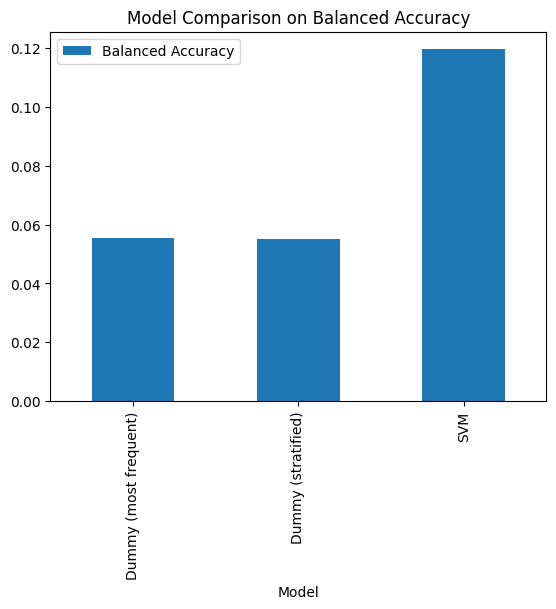

In [ ]:
# plot the accuracies
results_df = pd.DataFrame({
    'Model': ['Dummy (most frequent)', 'Dummy (stratified)', 'SVM'],
    'Balanced Accuracy': [dummy_acc, dummy2_acc, svm_acc]
})
results_df.plot.bar(x='Model', y='Balanced Accuracy', title='Model Comparison on Balanced Accuracy')
results_df

Compared to the baseline classifier, our model performs better. Still, the performance is quite poor with the accuracy being ~11.9%.

## 2. Experiment - find the optimal C parameter for the SVM

Having identified the optimal RARITY_THRESHOLD=2000, we now tune the C parameter to find the optimal regularization strength. The C parameter controls the trade-off between maximizing the margin and minimizing classification errors on the training set.

In [12]:
print("="*60)
print(f"Focused experiments: RARITY_THRESHOLD={BEST_THRESHOLD}")
print("="*60)

# Preprocess with best threshold
X_train, X_test, y_train, y_test = preprocess_crime(df, RARITY_THRESHOLD=BEST_THRESHOLD)

print(f"Classes: {y_train.nunique()}")
print(f"Original training size: {len(X_train):,}")

# Downsample
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train,
    train_size=SAMPLE_SIZE,
    stratify=y_train,
    random_state=42
)

print(f"Sample size: {len(X_train_sample):,}")
print(f"Samples per class (avg): {len(X_train_sample) / y_train_sample.nunique():.0f}")

# Check class distribution
class_dist = y_train_sample.value_counts()
print(f"Smallest class: {class_dist.min()} samples")
print(f"Largest class: {class_dist.max()} samples")


Focused experiments: RARITY_THRESHOLD=2000
Occurred_Time           2
Reported_Time           2
Crime_Subcategory     262
Precinct             3352
Sector               3346
Beat                 3298
Neighborhood         3366
dtype: int64
Number of NAs: Series([], dtype: int64)
Original target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                   131297
THEFT-SHOPLIFT                    48637
THEFT-OTH                         47275
VEH-THEFT-AUTO                    37840
BURGLARY-FORCE-RES                27984
                                  ...  
NARC-SMUGGLE-HEROIN                   1
HOMICIDE-NEG-MANS-GUN                 1
NARC-SELL-BARBITUATE                  1
NARC-MANUFACTURE-HALLUCINOGEN         1
HOMICIDE-NEG-MANS-WEAPON              1
Name: count, Length: 144, dtype: int64
Number of rare classes (less than 2000 instances): 113
New target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                 131297
THEFT-SHOPLIFT           

Now let's train the SVM with a bunch of C options to see which one performs the best.

In [13]:
# Now tune C parameter on this configuration
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
c_results = []

for C in C_values:
    print(f"\n--- Testing C={C} ---")
    
    model = LinearSVC(
        C=C,
        class_weight='balanced',
        max_iter=2000,
        random_state=42,
        verbose=1
    )
    
    start = time.time()
    model.fit(X_train_sample, y_train_sample)
    train_time = time.time() - start
    
    # Check convergence
    if hasattr(model, 'n_iter_'):
        print(f"Converged in {model.n_iter_} iterations")
    
    y_pred = model.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    
    c_results.append({
        'C': C,
        'balanced_accuracy': acc,
        'train_time': train_time,
        'converged': model.converged_ if hasattr(model, 'converged_') else True
    })
    
    print(f"Balanced Accuracy: {acc:.4f}")
    print(f"Time: {train_time:.1f}s")

df_c_results = pd.DataFrame(c_results)
print("\n" + "="*60)
print("C PARAMETER TUNING RESULTS")
print("="*60)
print(df_c_results)


--- Testing C=0.01 ---
[LibLinear]iter  1 act 4.508e+02 pre 4.506e+02 delta 7.881e-01 f 5.121e+02 |g| 1.203e+03 CG   2
iter  2 act 1.847e+00 pre 2.607e+00 delta 2.196e-01 f 6.132e+01 |g| 3.345e+01 CG   8
iter  3 act 4.626e-01 pre 4.531e-01 delta 2.196e-01 f 5.947e+01 |g| 2.680e+01 CG   5
iter  4 act 1.076e-01 pre 1.026e-01 delta 2.196e-01 f 5.901e+01 |g| 2.962e+00 CG  19
iter  5 act 3.101e-03 pre 3.012e-03 delta 2.196e-01 f 5.890e+01 |g| 8.799e-01 CG  18
iter  6 act 1.127e-04 pre 1.126e-04 delta 2.196e-01 f 5.890e+01 |g| 1.141e-01 CG  20
iter  7 act 2.614e-06 pre 2.614e-06 delta 2.196e-01 f 5.890e+01 |g| 1.033e-02 CG  23
iter  8 act 2.591e-08 pre 2.591e-08 delta 2.196e-01 f 5.890e+01 |g| 9.135e-04 CG  25
iter  1 act 4.518e+02 pre 4.516e+02 delta 7.866e-01 f 5.130e+02 |g| 1.206e+03 CG   2
iter  2 act 1.676e+00 pre 2.100e+00 delta 7.866e-01 f 6.118e+01 |g| 3.070e+01 CG   8
iter  3 act 2.309e-01 pre 2.194e-01 delta 7.866e-01 f 5.951e+01 |g| 1.942e+01 CG   3
iter  4 act 1.360e-01 pre 1.33

In [14]:
df_c_results

,C,balanced_accuracy,train_time,converged
0,0.01,0.120302,3.519755,True
1,0.10,0.119336,5.147745,True
2,1.00,0.119431,9.820767,True
3,10.00,0.119504,15.571409,True
4,100.00,0.119512,16.611174,True


array([[<Axes: >],
       [<Axes: >]], dtype=object)

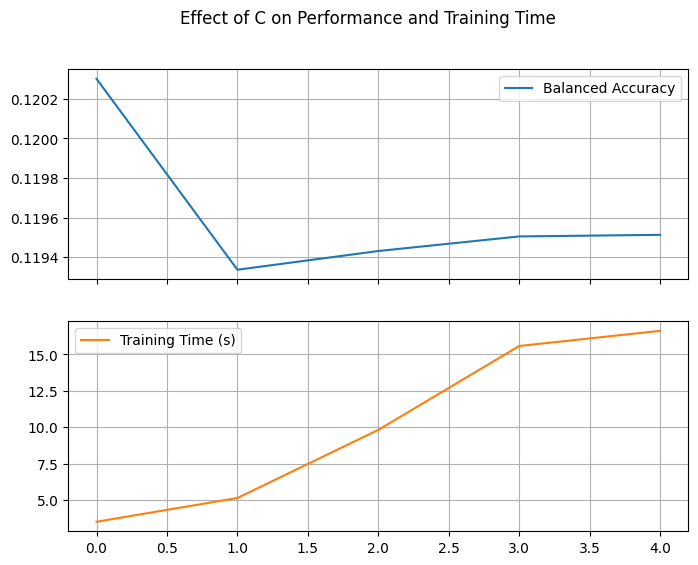

In [21]:
df_c_results_plot = df_c_results.copy()
# df_c_results_plot = df_c_results_plot.set_index('C')
df_c_results_plot = df_c_results_plot[['balanced_accuracy', 'train_time']]
df_c_results_plot.columns = ['Balanced Accuracy', 'Training Time (s)']
df_c_results_plot.plot(subplots=True, layout=(2,1), figsize=(8,6), title="Effect of C on Performance and Training Time", grid=True)

We can see that the C parameter (miscalssification penalty), which essentially determinines how many misclassifications are allowed during training, has very little effect on the model's performance in our case.

Thought the differences are minimal, there is a pattern that we can derive from the results. Notably, for very small penalty, the accuracy of the model is slightly higher. We can assume that with higher penalty a form of overfitting occurs and the model benefits more from being able to have a higher number of misclassifications on the training data. Still, the accuracy is for each model about the same, roughly 12%.

In [16]:
from sklearn.metrics import classification_report
import pandas as pd

# Using best model with C = 0.01 and BEST_THRESHOLD = 2000
model = LinearSVC(C=0.01, class_weight='balanced', max_iter=2000, random_state=42)
model.fit(X_train_sample, y_train_sample)
y_pred = model.predict(X_test)

# Detailed report
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()

# Remove aggregate rows
df_report = df_report[~df_report.index.isin(['accuracy', 'macro avg', 'weighted avg'])]
df_report = df_report.sort_values('f1-score')

print("="*60)
print("WORST PERFORMING CLASSES (Bottom 10)")
print("="*60)
print(df_report.head(10)[['precision', 'recall', 'f1-score', 'support']])

print("\n" + "="*60)
print("BEST PERFORMING CLASSES (Top 10)")
print("="*60)
print(df_report.tail(10)[['precision', 'recall', 'f1-score', 'support']])

# Confusion - which crimes are confused with each other?
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)
print(f"\n" + "="*60)
print("MOST CONFUSED PAIRS")
print("="*60)

# Find biggest off-diagonal elements
classes = sorted(y_test.unique())
confused_pairs = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i,j] > 100:  # At least 100 confusions
            confused_pairs.append({
                'true_class': classes[i],
                'predicted_as': classes[j],
                'count': cm[i,j]
            })

df_confused = pd.DataFrame(confused_pairs).sort_values('count', ascending=False)
print(df_confused.head(10))

WORST PERFORMING CLASSES (Bottom 10)
                            precision    recall  f1-score  support
THEFT-OTH                    0.000000  0.000000  0.000000   9455.0
BURGLARY-NOFORCE-NONRES      0.029412  0.000597  0.001171   1674.0
WEAPON-POSSESSION            0.001938  0.001894  0.001916    528.0
THEFT-BUILDING               0.166667  0.001866  0.003690   4288.0
SEXOFF-INDECENT LIBERTIES    0.005004  0.017327  0.007765    404.0
ASSLT-AGG-BODYFORCE          0.011494  0.008208  0.009577    731.0
BURGLARY-NOFORCE-RES         0.058140  0.006628  0.011899   3772.0
ROBBERY-BUSINESS-BODYFORCE   0.008333  0.028249  0.012870    531.0
ASSLT-AGG-WEAPON             0.042718  0.011299  0.017872   1947.0
ASSLT-AGG-DV-BODYFORCE       0.013354  0.030853  0.018640    551.0

BEST PERFORMING CLASSES (Top 10)
                             precision    recall  f1-score  support
SEXOFF-OTHER                  0.039951  0.122411  0.060241    531.0
OTHER                         0.238480  0.035688  0.0620

## 3. Experiment - holdout vs CV

The purpose of this experiment is to test two different approaches to training and testing the model - holdout and cross-validation. Cross-validation is a more sophisticated approach that allows us to get a better picutre of the model's performance on the dataset while aiming to erase the bias of the test-train split. The main question is if the measure accuracy will be notably different with CV compared to holdout.

In [17]:
## 3. Holdout vs Cross-Validation Comparison

from sklearn.model_selection import cross_val_score, StratifiedKFold

print("="*60)
print("HOLDOUT VS CROSS-VALIDATION COMPARISON")  
print("="*60)

# Method 1: Holdout (what we've been doing)
print("Method 1: Holdout Validation (80/20 split)")
model_holdout = LinearSVC(C=0.01, class_weight='balanced', max_iter=2000, random_state=42)

start = time.time()
model_holdout.fit(X_train_sample, y_train_sample)
holdout_time = time.time() - start

y_pred_holdout = model_holdout.predict(X_test)
holdout_acc = balanced_accuracy_score(y_test, y_pred_holdout)

print(f"  Balanced Accuracy: {holdout_acc:.4f}")
print(f"  Training Time: {holdout_time:.1f}s")
print(f"  Single train/test split\n")

# Method 2: Cross-validation (5-fold)
print("Method 2: Cross-Validation (5-fold stratified)")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start = time.time()
cv_scores = cross_val_score(
    LinearSVC(C=0.01, class_weight='balanced', max_iter=2000, random_state=42),
    X_train_sample, y_train_sample,  # CV on training data only
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"  CV Scores per fold: {[f'{s:.4f}' for s in cv_scores]}")
print(f"  Mean: {cv_scores.mean():.4f}")
print(f"  Std:  {cv_scores.std():.4f}")
print(f"  Training Time: {cv_time:.1f}s ({cv_time/holdout_time:.1f}x longer)\n")

# Comparison
print("="*60)
print("COMPARISON")
print("="*60)
print(f"Holdout:          {holdout_acc:.4f}")
print(f"CV Mean:          {cv_scores.mean():.4f}")
print(f"Difference:       {abs(holdout_acc - cv_scores.mean()):.4f}")
print(f"CV Std Dev:       ±{cv_scores.std():.4f}")

if abs(holdout_acc - cv_scores.mean()) < 0.02:
    print("\n✓ Results are similar - holdout split is representative")
else:
    print("\n⚠ Noticeable difference - performance varies with split")

print(f"\nComputational cost: CV took {cv_time/holdout_time:.1f}x longer")

HOLDOUT VS CROSS-VALIDATION COMPARISON
Method 1: Holdout Validation (80/20 split)
  Balanced Accuracy: 0.1203
  Training Time: 3.2s
  Single train/test split

Method 2: Cross-Validation (5-fold stratified)
  CV Scores per fold: ['0.1314', '0.1200', '0.1256', '0.1227', '0.1201']
  Mean: 0.1240
  Std:  0.0043
  Training Time: 12.7s (3.9x longer)

COMPARISON
Holdout:          0.1203
CV Mean:          0.1240
Difference:       0.0037
CV Std Dev:       ±0.0043

✓ Results are similar - holdout split is representative

Computational cost: CV took 3.9x longer


We can observe that the accuracy of the model using cross-validation and holdout is very similar, indicating that the holdout approach is sufficient for fast experimentation and that our single train-test split provides a reliable performance estimate.

## Conclusion

We investigated SVM classification for predicting crime types from spatiotemporal features (time and location) in Seattle's crime data.

**Key Findings:**

1. **Class Granularity Trade-off**: Performance improved from 5.9% (100 classes) to 17.8% (18 classes) as we grouped rare crimes, demonstrating a clear trade-off between classification detail and accuracy.

2. **C Parameter Insensitivity**: The regularization parameter C had negligible effect on performance (11.9-12.0% across all values), indicating that feature informativeness, not regularization, limits model performance.

3. **Above Baseline**: The SVM outperformed naive baselines (most-frequent, stratified), confirming it learned meaningful patterns.

4. **Crime-Specific Performance**: Certain crimes showed reasonable predictability while others performed at random-level, revealing which crime types have distinctive spatiotemporal signatures.

**Interpretation:**

The modest performance (11.9-17.8%) is appropriate given we only use time and location. Real crime prediction requires additional context: victim demographics, suspect information, circumstances, and physical evidence. The flat C-parameter response and consistently low accuracy suggest the problem's difficulty stems from limited features rather than model choice.

**Significance:**

Despite modest aggregate accuracy, this work:
- Identified which crime types are predictable from time/location alone
- Established that regularization is not the bottleneck
- Provides baseline performance for future work with richer features

**Future Work:**

Improvements would require: (1) additional temporal features (day of week, season), (2) interaction features (location × time), (3) non-linear kernels or ensemble methods, or (4) external data (weather, demographics, economic indicators).

This investigation demonstrates that crime type prediction from spatiotemporal features alone achieves limited but scientifically meaningful results, with performance constrained by feature availability rather than algorithmic limitations.

## Results for classifier comparison

In [19]:
# run the best model on the full test set
train_X, test_X, train_y, test_y = preprocess_crime(df, RARITY_THRESHOLD=BEST_THRESHOLD, seed=42, test_size=0.2)
train_X_sample, _, train_y_sample, _ = train_test_split(
    train_X, train_y,
    train_size=SAMPLE_SIZE,
    stratify=train_y,
    random_state=42
)

model = LinearSVC(C=0.01, class_weight='balanced', max_iter=2000, random_state=42)

start = time.time()
model.fit(train_X_sample, train_y_sample)
train_time = time.time() - start

y_pred = model.predict(test_X)

# Metrics as agreed with team
results = {
    'accuracy': accuracy_score(test_y, y_pred),
    'precision': precision_score(test_y, y_pred, average='macro', zero_division=0),
    'recall': recall_score(test_y, y_pred, average='macro', zero_division=0),
    'f1': f1_score(test_y, y_pred, average='macro', zero_division=0),
    'balanced_accuracy': balanced_accuracy_score(test_y, y_pred),
    'train_time': train_time,
    'n_samples_train': len(train_X_sample),
    'n_samples_test': len(test_X),
    'n_classes': len(np.unique(train_y_sample))
}

print(f"Dataset: Seattle Crime")
print(f"Train samples: {results['n_samples_train']:,}")
print(f"Test samples:  {results['n_samples_test']:,}")
print(f"Classes:       {results['n_classes']}")
print(f"Training time: {results['train_time']:.1f}s")
print()
print("Performance Metrics:")
print(f"  Accuracy:   {results['accuracy']:.4f}")
print(f"  Precision:  {results['precision']:.4f}")
print(f"  Recall:     {results['recall']:.4f}")
print(f"  F1-Score:   {results['f1']:.4f}")
print(f"  Bal. Acc:   {results['balanced_accuracy']:.4f}")

Occurred_Time           2
Reported_Time           2
Crime_Subcategory     262
Precinct             3352
Sector               3346
Beat                 3298
Neighborhood         3366
dtype: int64
Number of NAs: Series([], dtype: int64)
Original target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                   131297
THEFT-SHOPLIFT                    48637
THEFT-OTH                         47275
VEH-THEFT-AUTO                    37840
BURGLARY-FORCE-RES                27984
                                  ...  
NARC-SMUGGLE-HEROIN                   1
HOMICIDE-NEG-MANS-GUN                 1
NARC-SELL-BARBITUATE                  1
NARC-MANUFACTURE-HALLUCINOGEN         1
HOMICIDE-NEG-MANS-WEAPON              1
Name: count, Length: 144, dtype: int64
Number of rare classes (less than 2000 instances): 113
New target class distribution:  Primary_Offense_Description
THEFT-CARPROWL                 131297
THEFT-SHOPLIFT                  48637
THEFT-OTH                     